# This file creates models from the cleaned data. "pushshift_func.ipynb" and "comment_cleaning.ipynb" need to be ran before this file

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
# read in clean data
df_comment = pd.read_csv('../data/comment_clean.csv')

# Info

In [8]:
df_comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102486 entries, 0 to 102485
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   subreddit        102486 non-null  int64  
 1   body             102486 non-null  object 
 2   num_of_chars     102486 non-null  int64  
 3   word_count       102486 non-null  int64  
 4   capital_count    102486 non-null  int64  
 5   question_mark    102486 non-null  int64  
 6   exclaimation     102486 non-null  int64  
 7   dot_dot_dot      102486 non-null  int64  
 8   quotes           102486 non-null  int64  
 9   italics          102486 non-null  int64  
 10  bold             102486 non-null  int64  
 11  polarity         102486 non-null  float64
 12  subjectivity     102486 non-null  float64
 13  avg_word_length  102486 non-null  int64  
 14  stop_word_count  102486 non-null  int64  
dtypes: float64(2), int64(12), object(1)
memory usage: 11.7+ MB


In [69]:
df_comment['subreddit'].value_counts(normalize=True)

0    0.537384
1    0.462616
Name: subreddit, dtype: float64

# Functions

In [3]:
# Created by Jeff
def split_into_lemmas(text):
    '''return lowercased, lemmatizeed list of words as a string from a document passed in '''
   
    text = text.lower()
    lemmer = WordNetLemmatizer()
    return ' '.join([lemmer.lemmatize(word) for word in text.split()])

In [4]:
def model_func(estimator, params, data, display_coefs=False):
    # Function takes in an estimator, parameters for that estimator, and a data frame
    # display_coefs is an optional parameter. default is false. set to true to display dataframe of the coefs of words

    # features used and what is trying to be predicted
    X = data['body']
    y = data['subreddit']

    # splitting data to training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

    pipe = make_pipeline(TfidfVectorizer(preprocessor=split_into_lemmas), estimator)

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)

    # prints out best params and scores
    print('Best Params')
    for k,v in gs.best_params_.items():
        print(f'{k}: {v}')
    print('*' * 50)
    print('Scores')
    print(f'   Train: ', gs.score(X_train, y_train))
    print(f'    Test: ', gs.score(X_test, y_test))
    print(f'F1 Score: ', f1_score(y_test, gs.predict(X_test)))

    # if display_coefs is set to true, gets coefficients, saves them to a csv, and returns a dataframe of the coefs
    # if false, displays a confusion matrix
    if display_coefs:
        coefs = gs.best_estimator_.named_steps[str(estimator).lower()[:-2]].coef_
        cols = gs.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names_out()
        coef_df = pd.DataFrame(zip(cols, coefs[0])).sort_values(1)
        coef_df.rename(columns={0:'word', 1:'coef'}, inplace=True)
        coef_df.to_csv(f'../data/{str(estimator).lower()[:-2]}_coefs.csv', index=False)
        return coef_df
    else:
        ConfusionMatrixDisplay.from_estimator(
            gs.best_estimator_, 
            X_test, 
            y_test, 
            cmap='Blues', 
            display_labels=['mildlyinteresting', 'interestingasfuck']
        )
        plt.title('Confusion Matrix')

In [54]:
TfidfVectorizer().get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

# Models

Parameters listed were determined through many trials to maximize the models' performance.

### MultinomialNB

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 13000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.7582483347210658
    Test:  0.7091561938958707
F1 Score:  0.6557331608611291


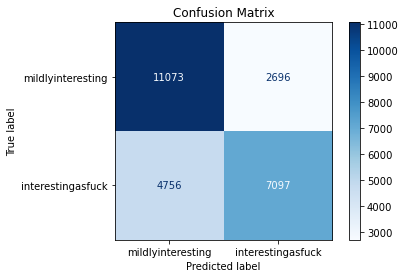

In [18]:
params_nb = {
    'multinomialnb__alpha': [1],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [12_000, 13_000]
}

model_func(MultinomialNB(), params_nb, df_comment)

### RandomForestClassifier

In [ ]:
params_rf = {
    'randomforestclassifier__max_depth': [20, None],
    'randomforestclassifier__max_features': [5, 10],
    'randomforestclassifier__n_estimators': [10, 100],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [7000]
}

model_func(RandomForestClassifier(), params_rf, df_comment)

### BaggingClassifier

In [ ]:
params_bc = {
    'baggingclassifier__n_estimators': [50],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.2],
    'tfidfvectorizer__max_features': [7000]
}

model_func(BaggingClassifier(), params_bc, df_comment)

### KNeighborsClassifier

In [ ]:
params_knn = {
    'kneighborsclassifier__n_neighbors': [5, 7],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidfvectorizer__max_df': [.1, .2],
    'tfidfvectorizer__max_features': [7000]
}

model_func(KNeighborsClassifier(), params_knn, df_comment)

### LogisticRegression

In [6]:
params_logreg = {
    'logisticregression__C': [1],
    'logisticregression__max_iter': [10_000],
    # 'logisticregression__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    # 'logisticregression__penalty': ['1', 'l2', 'elasticnet', 'none'],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [13_000]
}

model_func(LogisticRegression(), params_logreg, df_comment, display_coefs=True)

Best Params
logisticregression__C: 1
logisticregression__max_iter: 10000
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 13000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.7648834304746045
    Test:  0.708297556787136
F1 Score:  0.6689404677533665


,word,coef
6566,license,-5.074840
991,beanie,-4.989898
7167,mildly,-4.849861
11713,tooth,-4.729820
7643,nfts,-4.570500
...,...,...
1774,cell,3.948053
12994,zoo,4.099214
9728,rocket,4.248372
401,anaconda,4.507288


### VotingClassifier

Best Params
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 13000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
votingclassifier__logreg__C: 1
votingclassifier__nb__alpha: 1
**************************************************
Scores
   Train:  0.766548709408826
    Test:  0.7106783233159004
F1 Score:  0.6675039246467818


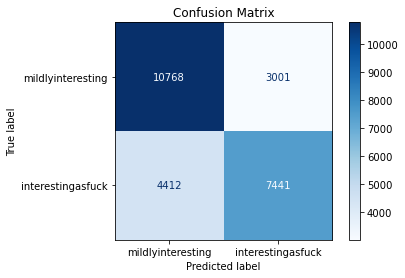

In [5]:
vc = VotingClassifier(
    [
        ('nb', MultinomialNB()),
        # ('rf', RandomForestClassifier()),
        ('logreg', LogisticRegression(max_iter=10_000))
    ],
    voting='soft'
)

params_vc = {
    'votingclassifier__nb__alpha': [1],
    'votingclassifier__logreg__C': [1],
    # 'votingclassifier__rf__max_features': [20],
    # 'votingclassifier__rf__n_estimators': [100],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [12_000, 13_000]
}

model_func(vc, params_vc, df_comment)

## Filtering data based on number of characters in a comment

This section was used for exploring the relationship between the number of characters in a comment and the models performance.

The models scores improved while filtering out these comments, but the usefullness of the model decreased in my opinion. By leaving simple comments like 'nice' or '+1' it was able to increase the range of comments to be applied to.

### Number of Characters > 10

In [8]:
df_comment_10 = df_comment[df_comment['num_of_chars'] > 10]

model_func(MultinomialNB(), params_nb, df_comment_10)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 13000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.7634143013100436
    Test:  0.7099111638760388
F1 Score:  0.6595887778631822


### Number of Characters > 20

In [9]:
df_comment_20 = df_comment[df_comment['num_of_chars'] > 20]

model_func(MultinomialNB(), params_nb, df_comment_20)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 13000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.7734394237872445
    Test:  0.7210397525278175
F1 Score:  0.6723071916693785


### Number of Characters > 30

In [10]:
df_comment_30 = df_comment[df_comment['num_of_chars'] > 30]

model_func(MultinomialNB(), params_nb, df_comment_30)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 13000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.7862580379372728
    Test:  0.729554003224073
F1 Score:  0.6805053005776678


### Number of Characters > 40

In [11]:
df_comment_40 = df_comment[df_comment['num_of_chars'] > 40]

model_func(MultinomialNB(), params_nb, df_comment_40)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 13000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.7990670972371726
    Test:  0.7383183487400279
F1 Score:  0.6899242253732464


### Number of Characters > 50

In [30]:
df_comment_50 = df_comment[df_comment['num_of_chars'] > 50]

params_nb = {
    'multinomialnb__alpha': [1],
    'tfidfvectorizer__min_df': [2],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [12_000]
}

model_func(MultinomialNB(), params_nb, df_comment_50)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 12000
tfidfvectorizer__min_df: 2
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.8085137977973024
    Test:  0.7484594253470933
F1 Score:  0.6998050682261208


### Number of Characters > 60

In [19]:
df_comment_60 = df_comment[df_comment['num_of_chars'] > 60]

params_nb = {
    'multinomialnb__alpha': [1],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [12_000]
}

model_func(MultinomialNB(), params_nb, df_comment_60)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 12000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.8174803510986174
    Test:  0.7600894931589364
F1 Score:  0.7112676056338028


### Number of Characters > 70

In [24]:
df_comment_70 = df_comment[df_comment['num_of_chars'] > 70]

params_nb = {
    'multinomialnb__alpha': [1],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [11_000]
}

model_func(MultinomialNB(), params_nb, df_comment_70)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 11000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.8264993577709713
    Test:  0.7627939142461964
F1 Score:  0.7169633384415891


### Number of Characters > 80

In [25]:
df_comment_80 = df_comment[df_comment['num_of_chars'] > 80]

params_nb = {
    'multinomialnb__alpha': [1],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [11_000]
}

model_func(MultinomialNB(), params_nb, df_comment_80)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 11000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.8377488399940128
    Test:  0.7660792457065888
F1 Score:  0.7224294086307939


### Number of Characters > 90

In [26]:
df_comment_90 = df_comment[df_comment['num_of_chars'] > 90]

params_nb = {
    'multinomialnb__alpha': [1],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [11_000]
}

model_func(MultinomialNB(), params_nb, df_comment_90)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 11000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.8398273892625968
    Test:  0.7809644670050762
F1 Score:  0.7420029895366218


### Number of Characters > 100

In [27]:
df_comment_100 = df_comment[df_comment['num_of_chars'] > 100]

params_nb = {
    'multinomialnb__alpha': [1],
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [10_000]
}

model_func(MultinomialNB(), params_nb, df_comment_100)

Best Params
multinomialnb__alpha: 1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 10000
tfidfvectorizer__min_df: 3
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.8422799696509864
    Test:  0.7924608819345661
F1 Score:  0.7517440871192785


### Number of Characters > 110

In [29]:
df_comment_110 = df_comment[df_comment['num_of_chars'] > 110]

params_nb = {
    'multinomialnb__alpha': [.1],
    'tfidfvectorizer__min_df': [2],
    'tfidfvectorizer__ngram_range': [(1,1)],
    'tfidfvectorizer__max_df': [.1],
    'tfidfvectorizer__max_features': [10_000]
}

model_func(MultinomialNB(), params_nb, df_comment_110)

Best Params
multinomialnb__alpha: 0.1
tfidfvectorizer__max_df: 0.1
tfidfvectorizer__max_features: 10000
tfidfvectorizer__min_df: 2
tfidfvectorizer__ngram_range: (1, 1)
**************************************************
Scores
   Train:  0.8662683094495267
    Test:  0.7985406091370558
F1 Score:  0.7685016405395552
